<div style="border:2px solid purple; padding:16px; border-radius:12px; background:#faf5ff;">

<h2 style="color:purple; margin-top:0;">🎯 Client Objective (Industry-Style)</h2>

<p style="font-size:16px;">
Build an <span style="color:red; font-weight:bold;">MVP Food Image Classification application</span> that can take a user-provided food photo and return the most likely dish category using the <span style="color:purple; font-weight:bold;">Food-101 dataset</span> as the baseline training/evaluation set.
</p>

<hr style="border:1px solid purple;">

<h3 style="color:purple;">✅ Goals</h3>
<ul style="font-size:15px;">
  <li>Train a <span style="color:red; font-weight:bold;">PyTorch-based CNN model</span> (custom/simple architecture) to classify food images into <span style="color:purple; font-weight:bold;">101 categories</span>.</li>
  <li>Provide an end-to-end pipeline covering:
    dataset download + preprocessing, training + validation, test evaluation, inference, and basic visualizations.</li>
</ul>

<h3 style="color:purple;">🧩 Functional Requirements</h3>
<ul style="font-size:15px;">
  <li><b>Input:</b> RGB image (<span style="color:red;">.jpg/.png</span>) from disk (extendable to webcam/mobile).</li>
  <li><b>Output:</b>
    <ul>
      <li><span style="color:purple; font-weight:bold;">Top-1 predicted class</span> + confidence score</li>
      <li><span style="color:purple; font-weight:bold;">Top-5 classes</span> + confidence scores</li>
    </ul>
  </li>
  <li><b>Training:</b> configurable image size, batch size, epochs, learning rate; save best checkpoint + final model.</li>
  <li><b>Reproducibility:</b> optional fixed random seed and consistent splits.</li>
</ul>

<h3 style="color:purple;">⚙️ Non-Functional Requirements</h3>
<ul style="font-size:15px;">
  <li>Must run on <span style="color:red; font-weight:bold;">Windows</span> with <span style="color:purple; font-weight:bold;">NVIDIA 1070 8GB GPU</span> (fallback to CPU if needed).</li>
  <li>Clear logs for progress (loss/accuracy per epoch) and hardware detection.</li>
  <li>Model export: <span style="color:red; font-weight:bold;">torch.save()</span> checkpoint and/or TorchScript.</li>
</ul>

<h3 style="color:purple;">📏 Success Metrics (Acceptance Criteria)</h3>
<ul style="font-size:15px;">
  <li><b>Top-1 Accuracy:</b> <span style="color:red; font-weight:bold;">≥ 60%</span> on Food-101 test split using the custom CNN.</li>
  <li><b>Top-5 Accuracy:</b> <span style="color:purple; font-weight:bold;">≥ 85%</span>.</li>
  <li><b>Latency:</b> inference <span style="color:red; font-weight:bold;">&lt; 300 ms/image</span> on GPU for 224×224 input (excluding disk read).</li>
  <li><b>Quality checks:</b> class count = 101, correct train/test sizes, valid shapes/labels, no OOM on 8GB VRAM.</li>
</ul>

<h3 style="color:purple;">📦 Deliverables</h3>
<ol style="font-size:15px;">
  <li>Environment setup checks</li>
  <li>Dataset loading + visualization + sanity checks</li>
  <li>Simple custom CNN model definition</li>
  <li>Training loop + evaluation</li>
  <li>Inference demo on new images</li>
  <li>Saved model artifacts + training plots</li>
</ol>

</div>


# Step 1 — Imports + auto-install + environment check

In [1]:
# Cell 1: Basic environment info
import sys, platform
print("Python:", sys.version.split()[0])
print("OS:", platform.platform())

Python: 3.11.7
OS: Windows-10-10.0.26200-SP0


In [2]:
# Cell 2: Auto-install missing packages
import importlib, subprocess, sys

required = [
    "torch",
    "torchvision",
    "numpy",
    "matplotlib",
    "tqdm",
    "Pillow"
]

missing = []
for pkg in required:
    try:
        importlib.import_module(pkg if pkg != "Pillow" else "PIL")
    except ImportError:
        missing.append(pkg)

if missing:
    print("Missing packages:", missing)
    cmd = [sys.executable, "-m", "pip", "install", "-U"] + missing
    print("Running:", " ".join(cmd))
    subprocess.check_call(cmd)
else:
    print("All required packages are already installed ✅")

All required packages are already installed ✅


In [3]:
# Cell 3: Import everything we need (Food-101 CNN app)
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import Food101
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
#from tqdm.auto import tqdm

print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)

torch: 2.4.0+cu118
torchvision: 0.19.0+cu118


In [4]:
# Cell 4: GPU / CUDA check (important for your 1070)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("CUDA version (torch):", torch.version.cuda)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

CUDA available: True
GPU: NVIDIA GeForce GTX 1070
CUDA version (torch): 11.8
Using device: cuda


# Step 2 — Load Food-101 + sanity checks + visualization (PyTorch)

In [5]:
# Cell 1: Imports for Step 2
import os, random
import numpy as np
import torch
from torchvision.datasets import Food101
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [6]:
# Cell 2: Reproducibility + device
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Device: cuda
GPU: NVIDIA GeForce GTX 1070


In [7]:
# Cell 3: Define transforms (224x224, standard)
IMG_SIZE = 224

train_tfm = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_tfm = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
])

In [8]:
# Cell 4: Download + load Food-101
data_root = "data"

train_ds = Food101(root=data_root, split="train", download=True, transform=train_tfm)
test_ds  = Food101(root=data_root, split="test",  download=True, transform=test_tfm)

print("Train samples:", len(train_ds))
print("Test samples :", len(test_ds))
print("Classes      :", len(train_ds.classes))
print("Example class names:", train_ds.classes[:10])

Train samples: 75750
Test samples : 25250
Classes      : 101
Example class names: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [9]:
# Cell 5: Sanity check: class count + expected split sizes
assert len(train_ds.classes) == 101, "Food-101 should have 101 classes"
assert len(train_ds) == 75750, "Expected 75,750 train images (101*750)"
assert len(test_ds) == 25250, "Expected 25,250 test images (101*250)"
print("✅ Split sizes + class count look correct")

✅ Split sizes + class count look correct


In [10]:
# Cell 6: Check a sample (shape, dtype, label mapping)
x, y = train_ds[0]
print("Image tensor shape:", tuple(x.shape), "(C,H,W)")
print("dtype:", x.dtype, "min/max:", float(x.min()), float(x.max()))
print("Label id:", y, "-> class name:", train_ds.classes[y])

Image tensor shape: (3, 224, 224) (C,H,W)
dtype: torch.float32 min/max: 0.007843137718737125 1.0
Label id: 23 -> class name: churros


In [11]:
# Cell 7: DataLoader setup (Windows-friendly)
BATCH_SIZE = 64

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, pin_memory=True, persistent_workers=True
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True, persistent_workers=True
)

xb, yb = next(iter(train_loader))
print("Batch images:", xb.shape, "Batch labels:", yb.shape)

Batch images: torch.Size([64, 3, 224, 224]) Batch labels: torch.Size([64])


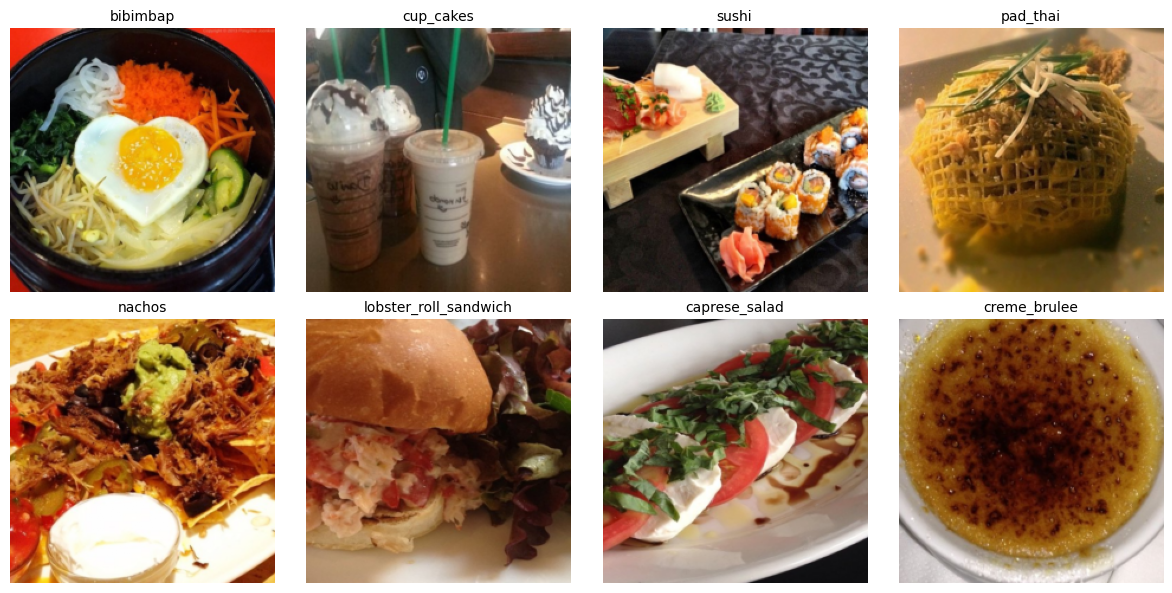

In [12]:
# Cell 8: Visualize a few samples (denormalized since we didn't normalize yet)
def show_batch(images, labels, classes, n=8):
    images = images[:n].cpu()
    labels = labels[:n].cpu()
    ncols = 4
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(nrows, ncols, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(classes[int(labels[i])], fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_batch(xb, yb, train_ds.classes, n=8)

In [13]:
# Cell 9: Quick "data order" sanity checks (randomness + label distribution sample)
labels_sample = []
for i in range(2000):
    _, y = train_ds[i]
    labels_sample.append(int(y))

unique = len(set(labels_sample))
print("Unique classes in first 2000 samples:", unique, "/ 101 (not expected to be all 101)")
print("First 20 labels:", labels_sample[:20])

Unique classes in first 2000 samples: 3 / 101 (not expected to be all 101)
First 20 labels: [23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23]


# Step 3 — Define a simple custom CNN + loss/optimizer + metrics (Top-1/Top-5)

In [14]:
# Cell 1: Simple CNN model (lightweight, Food-101 = 101 classes)
import torch
import torch.nn as nn
import torch.nn.functional as F

NUM_CLASSES = 101

class SimpleFoodCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.features = nn.Sequential(
            # 224 -> 112
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # 112 -> 56
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # 56 -> 28
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # 28 -> 14
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # 14 -> 7
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),   # (B, C, 1, 1)
            nn.Flatten(),              # (B, C)
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleFoodCNN(num_classes=NUM_CLASSES).to(device)
print(model.__class__.__name__)

SimpleFoodCNN


In [15]:
# Cell 2: Parameter count (sanity check)
num_params = sum(p.numel() for p in model.parameters())
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total params     :", f"{num_params:,}")
print("Trainable params :", f"{num_trainable:,}")

Total params     : 1,005,925
Trainable params : 1,005,925


In [16]:
# Cell 3: Loss + optimizer
criterion = nn.CrossEntropyLoss()

LR = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("Loss: CrossEntropyLoss")
print("Optimizer: Adam, LR =", LR)

Loss: CrossEntropyLoss
Optimizer: Adam, LR = 0.001


In [17]:
# Cell A: (Re)define topk_accuracy if needed
import torch

@torch.no_grad()
def topk_accuracy(logits, targets, k=1):
    _, pred = logits.topk(k, dim=1, largest=True, sorted=True)
    correct = pred.eq(targets.view(-1, 1)).any(dim=1).float()
    return correct.mean().item()

print("topk_accuracy ready ✅")

topk_accuracy ready ✅


In [18]:
# Cell 5: One forward pass on a batch (shape checks)
xb, yb = next(iter(train_loader))
xb = xb.to(device, non_blocking=True)
yb = yb.to(device, non_blocking=True)

logits = model(xb)
print("Input batch :", tuple(xb.shape))
print("Logits      :", tuple(logits.shape), "(should be B x 101)")

loss_val = criterion(logits, yb).item()
acc1 = topk_accuracy(logits, yb, k=1)
acc5 = topk_accuracy(logits, yb, k=5)

print("Loss (1 batch):", round(loss_val, 4))
print("Top-1 acc      :", round(acc1 * 100, 2), "%")
print("Top-5 acc      :", round(acc5 * 100, 2), "%")

Input batch : (64, 3, 224, 224)
Logits      : (64, 101) (should be B x 101)
Loss (1 batch): 4.8866
Top-1 acc      : 4.69 %
Top-5 acc      : 6.25 %


In [19]:
# Cell 6: Quick VRAM-friendly knobs (optional)
torch.backends.cudnn.benchmark = True  # speeds up convs for fixed input size
print("cudnn.benchmark =", torch.backends.cudnn.benchmark)

cudnn.benchmark = True


# Step 4 — Training loop + evaluation loop + checkpointing + plots (Food-101, custom CNN)

In [20]:
# Cell 1: Training config
from pathlib import Path
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

EPOCHS = 10
SAVE_DIR = Path("runs_food101_simplecnn")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
CKPT_PATH = SAVE_DIR / "best_model.pt"

print("Epochs:", EPOCHS)
print("Checkpoint:", CKPT_PATH)

Epochs: 10
Checkpoint: runs_food101_simplecnn\best_model.pt


In [21]:
# Cell 2: One epoch train function
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_acc1 = 0.0
    running_acc5 = 0.0
    n_batches = 0

    pbar = tqdm(loader, desc="Train", leave=False)
    for xb, yb in pbar:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        acc1 = topk_accuracy(logits, yb, k=1)
        acc5 = topk_accuracy(logits, yb, k=5)

        running_loss += loss.item()
        running_acc1 += acc1
        running_acc5 += acc5
        n_batches += 1

        pbar.set_postfix(loss=f"{loss.item():.3f}", acc1=f"{acc1*100:.1f}%", acc5=f"{acc5*100:.1f}%")

    return running_loss / n_batches, running_acc1 / n_batches, running_acc5 / n_batches

In [22]:
# Cell B: (Re)define eval_one_epoch
from tqdm import tqdm

@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc1 = 0.0
    running_acc5 = 0.0
    n_batches = 0

    pbar = tqdm(loader, desc="Eval ", leave=False)
    for xb, yb in pbar:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = model(xb)
        loss = criterion(logits, yb)

        acc1 = topk_accuracy(logits, yb, k=1)
        acc5 = topk_accuracy(logits, yb, k=5)

        running_loss += loss.item()
        running_acc1 += acc1
        running_acc5 += acc5
        n_batches += 1

        pbar.set_postfix(loss=f"{loss.item():.3f}", acc1=f"{acc1*100:.1f}%", acc5=f"{acc5*100:.1f}%")

    return running_loss / n_batches, running_acc1 / n_batches, running_acc5 / n_batches

print("eval_one_epoch ready ✅")

eval_one_epoch ready ✅


In [23]:
# Cell 4: Training loop with best-checkpoint saving
history = {
    "train_loss": [], "train_acc1": [], "train_acc5": [],
    "test_loss":  [], "test_acc1":  [], "test_acc5":  []
}

best_test_acc1 = -1.0

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_a1, tr_a5 = train_one_epoch(model, train_loader, optimizer, criterion, device)
    te_loss, te_a1, te_a5 = eval_one_epoch(model, test_loader, criterion, device)

    history["train_loss"].append(tr_loss)
    history["train_acc1"].append(tr_a1)
    history["train_acc5"].append(tr_a5)
    history["test_loss"].append(te_loss)
    history["test_acc1"].append(te_a1)
    history["test_acc5"].append(te_a5)

    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train loss {tr_loss:.3f} acc1 {tr_a1*100:.2f}% acc5 {tr_a5*100:.2f}% | "
          f"test  loss {te_loss:.3f} acc1 {te_a1*100:.2f}% acc5 {te_a5*100:.2f}% | "
          f"time {dt/60:.1f} min")

    if te_a1 > best_test_acc1:
        best_test_acc1 = te_a1
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "test_acc1": te_a1,
            "test_acc5": te_a5,
        }, CKPT_PATH)
        print(f"✅ Saved new best model: test acc1 {best_test_acc1*100:.2f}%")

Epoch 01/10 | train loss 3.981 acc1 9.76% acc5 28.13% | test  loss 4.093 acc1 8.85% acc5 26.83% | time 5.5 min
✅ Saved new best model: test acc1 8.85%


Epoch 02/10 | train loss 3.399 acc1 19.47% acc5 45.37% | test  loss 3.291 acc1 21.84% acc5 48.20% | time 4.3 min
✅ Saved new best model: test acc1 21.84%


Epoch 03/10 | train loss 3.009 acc1 27.08% acc5 55.82% | test  loss 3.051 acc1 25.83% acc5 54.25% | time 4.3 min
✅ Saved new best model: test acc1 25.83%


Epoch 04/10 | train loss 2.728 acc1 33.20% acc5 62.54% | test  loss 2.368 acc1 40.66% acc5 70.49% | time 4.2 min
✅ Saved new best model: test acc1 40.66%


Epoch 05/10 | train loss 2.531 acc1 37.81% acc5 66.83% | test  loss 2.413 acc1 39.57% acc5 69.59% | time 4.1 min


Epoch 06/10 | train loss 2.374 acc1 41.20% acc5 69.83% | test  loss 2.433 acc1 38.43% acc5 68.89% | time 4.1 min


Epoch 07/10 | train loss 2.255 acc1 44.03% acc5 72.30% | test  loss 2.138 acc1 45.54% acc5 74.87% | time 4.1 min
✅ Saved new best model: test acc1 45.54%


Epoch 08/10 | train loss 2.150 acc1 46.29% acc5 74.37% | test  loss 2.253 acc1 43.83% acc5 72.95% | time 4.3 min


Epoch 09/10 | train loss 2.057 acc1 48.08% acc5 75.95% | test  loss 1.905 acc1 51.40% acc5 79.42% | time 4.3 min
✅ Saved new best model: test acc1 51.40%


Epoch 10/10 | train loss 1.996 acc1 49.71% acc5 77.18% | test  loss 1.827 acc1 53.36% acc5 81.00% | time 4.3 min
✅ Saved new best model: test acc1 53.36%


# Step 5 — Inference + Visualization

In [24]:
# Cell 2: Load best checkpoint (edit path if yours differs)
CKPT_PATH = Path("runs_food101_simplecnn/best_model.pt")

if CKPT_PATH.exists():
    ckpt = torch.load(CKPT_PATH, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    model.eval()
    print("✅ Loaded checkpoint:", CKPT_PATH)
    if "epoch" in ckpt:
        print("Best epoch:", ckpt["epoch"])
    if "test_acc1" in ckpt:
        print("Best test top-1:", round(float(ckpt["test_acc1"])*100, 2), "%")
else:
    model.eval()
    print("⚠️ Checkpoint not found, using current model weights:", CKPT_PATH)

✅ Loaded checkpoint: runs_food101_simplecnn\best_model.pt
Best epoch: 10
Best test top-1: 53.36 %


C:\Users\Dr.PVVK\AppData\Local\Temp\ipykernel_5404\687835369.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location=device)


In [25]:
# Cell 3: Inference transform (consistent with your test pipeline)
IMG_SIZE = 224
infer_tfm = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
])

classes = train_ds.classes
print("Classes:", len(classes))

Classes: 101


In [26]:
# Cell 4: Predict Top-k on a PIL image
@torch.no_grad()
def predict_topk_pil(model, pil_img, classes, device, k=5):
    x = infer_tfm(pil_img).unsqueeze(0).to(device, non_blocking=True)  # (1,3,H,W)
    logits = model(x)
    probs = torch.softmax(logits, dim=1).squeeze(0)                    # (101,)
    top_probs, top_idx = probs.topk(k)

    results = [(classes[int(i)], float(p)) for i, p in zip(top_idx, top_probs)]
    return results

In [27]:
# Cell 5: Predict Top-5 for a single image path (edit img_path)
# Example: img_path = r"C:\Users\...\my_food.jpg"
img_path = r"PUT_YOUR_IMAGE_PATH_HERE.jpg"

pil_img = Image.open(img_path).convert("RGB")
plt.figure(figsize=(4,4)); plt.imshow(pil_img); plt.axis("off"); plt.show()

preds = predict_topk_pil(model, pil_img, classes, device, k=5)
for rank, (name, p) in enumerate(preds, start=1):
    print(f"Top-{rank}: {name:25s}  prob={p:.4f}")

NameError: name 'Image' is not defined

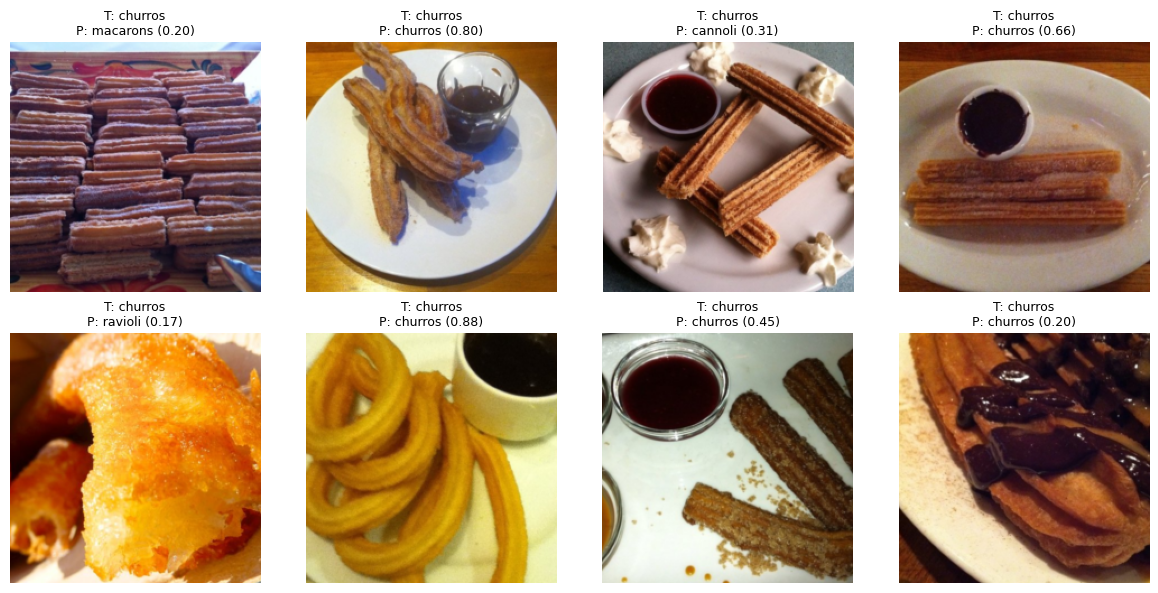

In [28]:
# Cell 6: Visualize predictions on a batch from test_loader
@torch.no_grad()
def show_test_batch_predictions(model, loader, classes, device, n=8):
    model.eval()
    xb, yb = next(iter(loader))
    xb = xb.to(device, non_blocking=True)
    yb = yb.to(device, non_blocking=True)

    probs = torch.softmax(model(xb), dim=1)
    pred = probs.argmax(dim=1)
    conf = probs.max(dim=1).values

    xb = xb[:n].cpu()
    yb = yb[:n].cpu()
    pred = pred[:n].cpu()
    conf = conf[:n].cpu()

    ncols = 4
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(nrows, ncols, i + 1)
        img = xb[i].permute(1,2,0).numpy()
        plt.imshow(img)
        t = classes[int(yb[i])]
        p = classes[int(pred[i])]
        c = float(conf[i])
        plt.title(f"T: {t}\nP: {p} ({c:.2f})", fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_test_batch_predictions(model, test_loader, classes, device, n=8)

In [29]:
# Cell 7: Reusable API-like helper (returns list of (class, prob))
def classify_image_path(image_path, k=5):
    pil_img = Image.open(image_path).convert("RGB")
    return predict_topk_pil(model, pil_img, classes, device, k=k)

print("✅ classify_image_path(path, k=5) is ready")

✅ classify_image_path(path, k=5) is ready


# Load best model checkpoint (recommended)

In [30]:
from pathlib import Path
import torch

CKPT_PATH = Path("runs_food101_simplecnn/best_model.pt")
ckpt = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()

print("Loaded:", CKPT_PATH)
print("Best epoch:", ckpt.get("epoch", "NA"))
print("Best test top-1:", round(float(ckpt.get("test_acc1", 0))*100, 2), "%")
print("Best test top-5:", round(float(ckpt.get("test_acc5", 0))*100, 2), "%")

C:\Users\Dr.PVVK\AppData\Local\Temp\ipykernel_5404\3680136774.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location=device)


Loaded: runs_food101_simplecnn\best_model.pt
Best epoch: 10
Best test top-1: 53.36 %
Best test top-5: 81.0 %


# Plot training curves (from history)

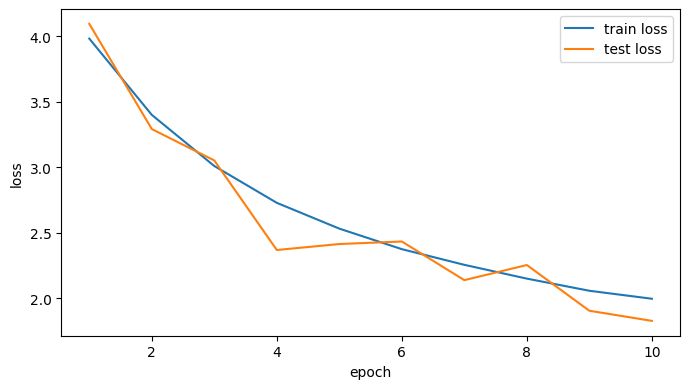

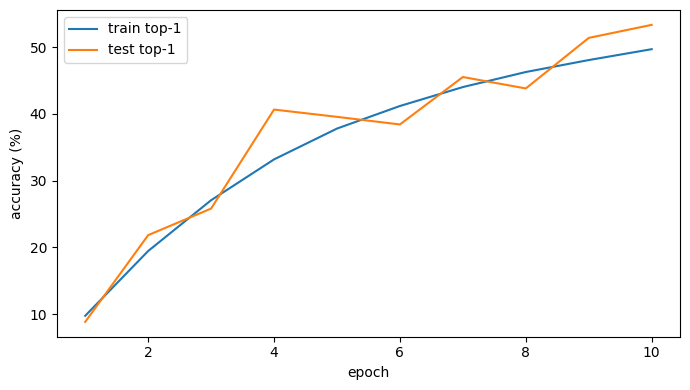

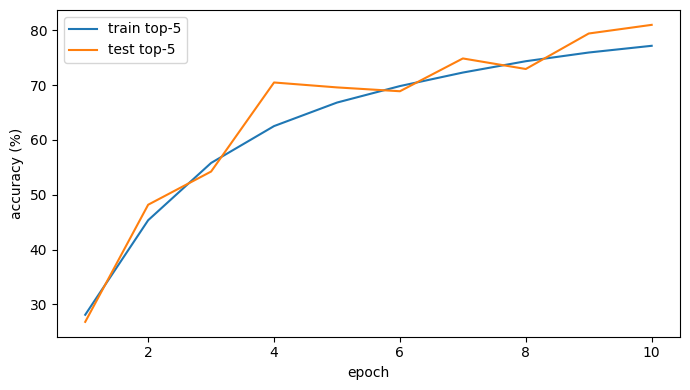

In [31]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs, history["train_loss"], label="train loss")
plt.plot(epochs, history["test_loss"],  label="test loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(epochs, np.array(history["train_acc1"])*100, label="train top-1")
plt.plot(epochs, np.array(history["test_acc1"])*100,  label="test top-1")
plt.xlabel("epoch"); plt.ylabel("accuracy (%)"); plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(epochs, np.array(history["train_acc5"])*100, label="train top-5")
plt.plot(epochs, np.array(history["test_acc5"])*100,  label="test top-5")
plt.xlabel("epoch"); plt.ylabel("accuracy (%)"); plt.legend(); plt.tight_layout()
plt.show()

# Compute predictions on the test set (Top-1/Top-5 + labels)

In [32]:
import torch
from tqdm import tqdm

@torch.no_grad()
def evaluate_and_collect(model, loader, device, num_classes=101):
    model.eval()
    correct1 = 0
    correct5 = 0
    total = 0

    all_true = []
    all_pred = []

    for xb, yb in tqdm(loader, desc="Collect test predictions"):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = model(xb)

        # Top-1
        pred1 = logits.argmax(dim=1)

        # Top-5
        top5 = logits.topk(5, dim=1).indices
        hit5 = top5.eq(yb.view(-1,1)).any(dim=1)

        correct1 += (pred1 == yb).sum().item()
        correct5 += hit5.sum().item()
        total += yb.size(0)

        all_true.append(yb.detach().cpu())
        all_pred.append(pred1.detach().cpu())

    all_true = torch.cat(all_true).numpy()
    all_pred = torch.cat(all_pred).numpy()

    top1_acc = correct1 / total
    top5_acc = correct5 / total
    return top1_acc, top5_acc, all_true, all_pred

top1_acc, top5_acc, y_true, y_pred = evaluate_and_collect(model, test_loader, device, num_classes=101)
print("Test Top-1 Accuracy:", round(top1_acc*100, 2), "%")
print("Test Top-5 Accuracy:", round(top5_acc*100, 2), "%")
print("y_true shape:", y_true.shape, "y_pred shape:", y_pred.shape)

Collect test predictions: 100%|██████████████████████████████████████████████████████| 395/395 [00:43<00:00,  9.08it/s]


Test Top-1 Accuracy: 53.32 %
Test Top-5 Accuracy: 80.99 %
y_true shape: (25250,) y_pred shape: (25250,)


# Confusion matrix (raw + normalized)

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def confusion_matrix_np(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

classes = train_ds.classes
num_classes = len(classes)

cm = confusion_matrix_np(y_true, y_pred, num_classes)
print("Confusion matrix shape:", cm.shape)

Confusion matrix shape: (101, 101)


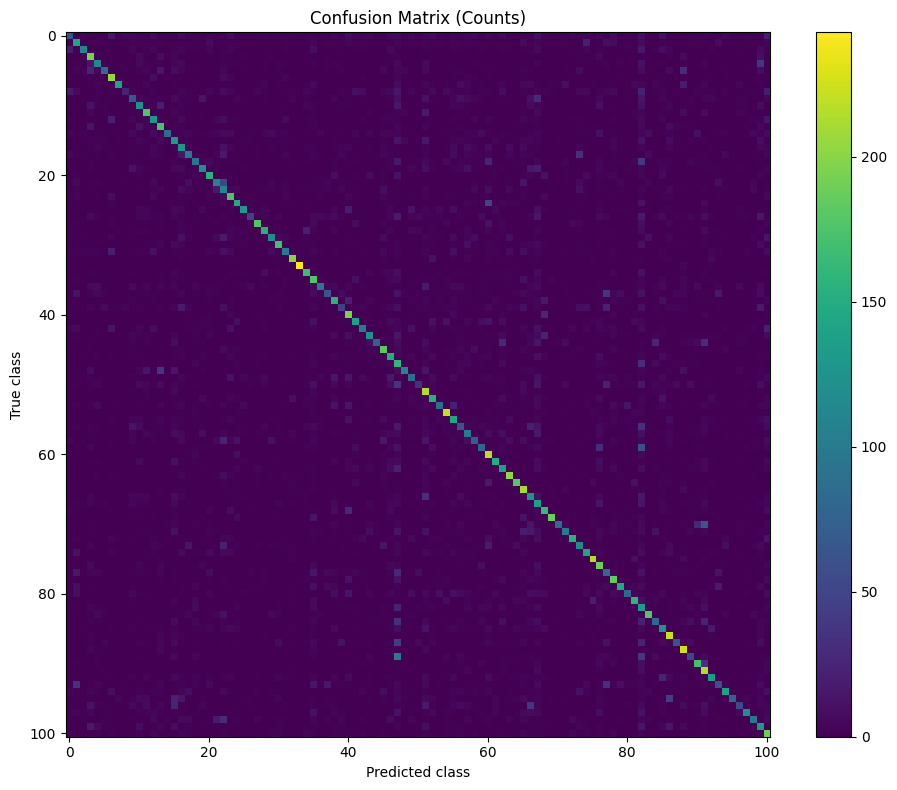

In [34]:
# Plot confusion matrix (raw counts)
plt.figure(figsize=(10, 8))
plt.imshow(cm)
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.colorbar()
plt.tight_layout()
plt.show()

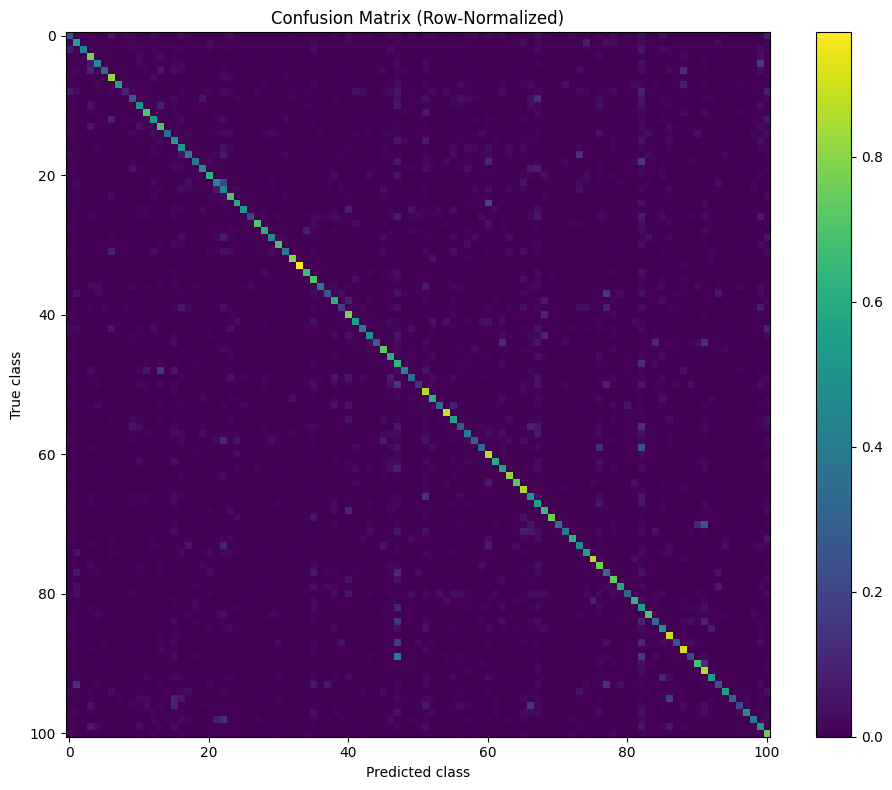

In [35]:
# Plot confusion matrix (row-normalized)
cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

plt.figure(figsize=(10, 8))
plt.imshow(cm_norm)
plt.title("Confusion Matrix (Row-Normalized)")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.colorbar()
plt.tight_layout()
plt.show()

In [36]:
# List top confusions (excluding diagonal)
cm_off = cm.copy()
np.fill_diagonal(cm_off, 0)

pairs = []
for i in range(num_classes):
    j = cm_off[i].argmax()
    if cm_off[i, j] > 0:
        pairs.append((cm_off[i, j], i, j))

pairs.sort(reverse=True)
print("Top confusions (true -> predicted):")
for count, i, j in pairs[:15]:
    print(f"{classes[i]:25s} -> {classes[j]:25s}  count={count}")

Top confusions (true -> predicted):
shrimp_and_grits          -> gnocchi                    count=99
pad_thai                  -> spaghetti_carbonara        count=65
lasagna                   -> ravioli                    count=59
chocolate_cake            -> chocolate_mousse           count=53
clam_chowder              -> lobster_bisque             count=50
sushi                     -> sashimi                    count=45
scallops                  -> gnocchi                    count=42
tacos                     -> nachos                     count=39
chicken_curry             -> ravioli                    count=39
beef_tartare              -> tuna_tartare               count=39
grilled_salmon            -> gnocchi                    count=38
greek_salad               -> caprese_salad              count=37
filet_mignon              -> pork_chop                  count=37
steak                     -> baby_back_ribs             count=35
spaghetti_bolognese       -> spaghetti_carbonara      

# Extra metrics: Precision/Recall/F1 (classification report)

In [37]:
import importlib, subprocess, sys

try:
    import sklearn
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "scikit-learn"])

In [38]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=classes, digits=3, zero_division=0)
print(report)

                         precision    recall  f1-score   support

              apple_pie      0.409     0.244     0.306       250
         baby_back_ribs      0.478     0.568     0.519       250
                baklava      0.880     0.440     0.587       250
         beef_carpaccio      0.496     0.772     0.604       250
           beef_tartare      0.557     0.452     0.499       250
             beet_salad      0.748     0.344     0.471       250
               beignets      0.623     0.820     0.708       250
               bibimbap      0.891     0.556     0.685       250
          bread_pudding      0.697     0.092     0.163       250
      breakfast_burrito      0.372     0.268     0.312       250
             bruschetta      0.482     0.488     0.485       250
           caesar_salad      0.646     0.708     0.676       250
                cannoli      0.564     0.508     0.535       250
          caprese_salad      0.496     0.692     0.578       250
            carrot_cake 